# Predict Rating

We will try to predict Airbnb ratings here using the listing data...

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopy.distance as dist
import seaborn as sns
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

import helper as hlp

%matplotlib inline
plt.style.use('seaborn-poster')

### Analyzing Ratings

In [167]:
boston_listings = pd.read_csv('data/boston/listings.csv', parse_dates=True)
seattle_listings = pd.read_csv('data/seattle/listings.csv', parse_dates=True)

In [126]:
boston_listings['review_scores_rating'].value_counts()

100.0    628
93.0     205
96.0     197
95.0     171
97.0     168
90.0     163
80.0     160
98.0     153
94.0     109
92.0     105
91.0      88
87.0      87
88.0      69
99.0      65
89.0      56
86.0      47
85.0      39
84.0      34
60.0      33
83.0      30
70.0      19
82.0      16
75.0      16
73.0      14
78.0      12
40.0      11
79.0      10
77.0       9
76.0       7
81.0       7
20.0       6
64.0       5
74.0       5
67.0       4
71.0       4
50.0       3
65.0       3
68.0       2
47.0       2
66.0       2
48.0       1
72.0       1
53.0       1
58.0       1
69.0       1
55.0       1
62.0       1
46.0       1
Name: review_scores_rating, dtype: int64

In [168]:
boston_listings['review_scores_rating'].fillna(-1, inplace=True)

In [128]:
rating_cnts = boston_listings['review_scores_rating'].value_counts().sort_index()

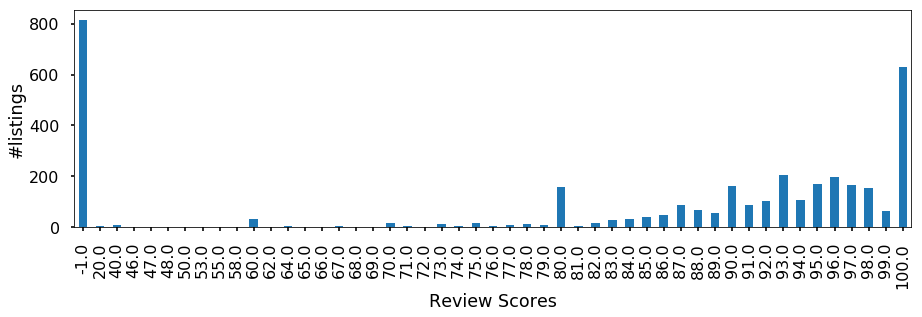

In [129]:
plt.figure(figsize =(15,4))
rating_cnts.plot(kind='bar')
plt.xlabel('Review Scores')
plt.ylabel('#listings')
plt.savefig('img/Boston_review_scores_dist.png', bbox_inches="tight");

There are more than 800 reviews which arent rated, if we scrap those unlabeled data we will have even lesser data to work with. 
Secondly the barplot shows that the ratings are skewed to the higher side.

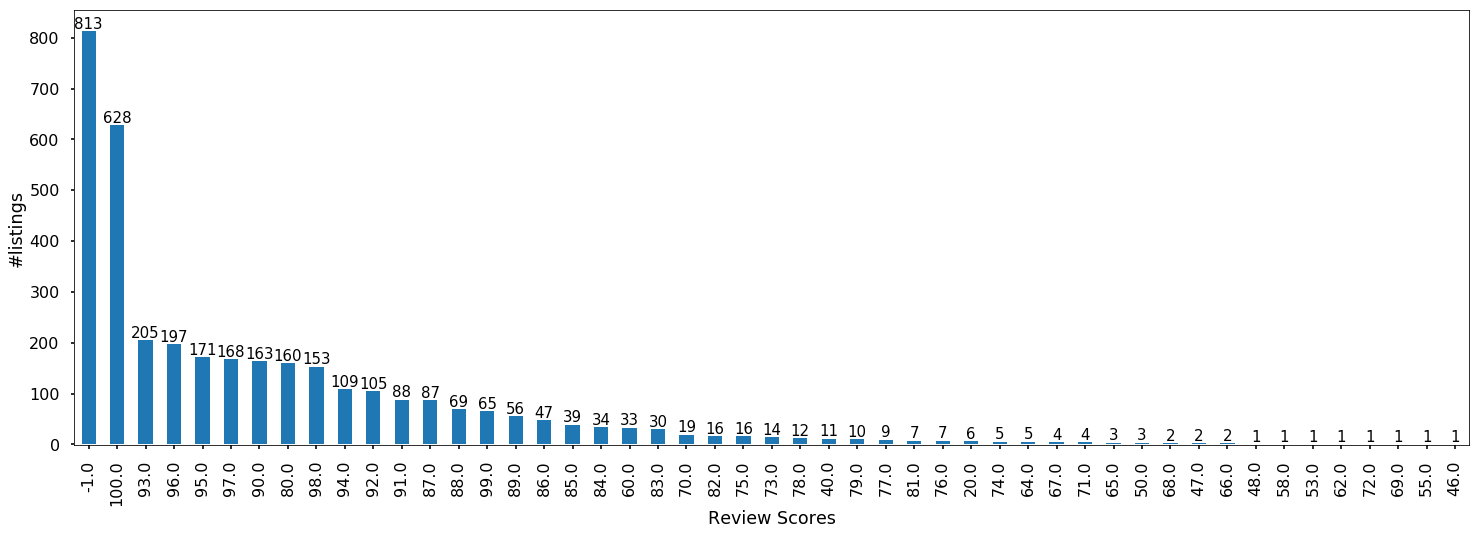

In [135]:
plt.figure(figsize =(25,8))
ax = boston_listings.review_scores_rating.value_counts().plot(kind='bar')
for p in ax.patches:
    height = p.get_height()
    ax.text((p.get_x() + p.get_width()/2.),
            height + 5,
            '%d' % int(height),
            ha='center',
            color='black',
            fontsize=15)
plt.ylim(bottom = -2)
plt.xlabel('Review Scores')
plt.ylabel('#listings')
plt.savefig('img/Boston_review_scores_dist_wdnums.png', bbox_inches="tight");

We can see the numbers here. Let us bin the data - 

In [142]:
def bin_rating(rating):
    """
    Map continuous rating to 6 discrete categories
    
    Parameters:
    rating: a conitunous rating
    
    Returns:
    binned rating in one of the values ([90-100], [80-90], [60-80], [20-60], [0-20], [Unrated])
    
    """
    if rating > 90.0:
        return '90-100'
    elif rating <= 90.0 and rating > 80.0:
        return '80-90'
    elif rating <= 80.0 and rating > 60.0:
        return '60-80'
    elif rating <= 60.0 and rating > 20.0:
        return '20-60'
    elif rating <= 20.0 and rating > 0.0:
        return '0-20'
    else:
        return 'Unrated'
    assert 0  # unexpected rating

In [169]:
boston_listings['rating_bins'] = boston_listings['review_scores_rating'].map(bin_rating)
total = boston_listings.rating_bins.count()
total

3585

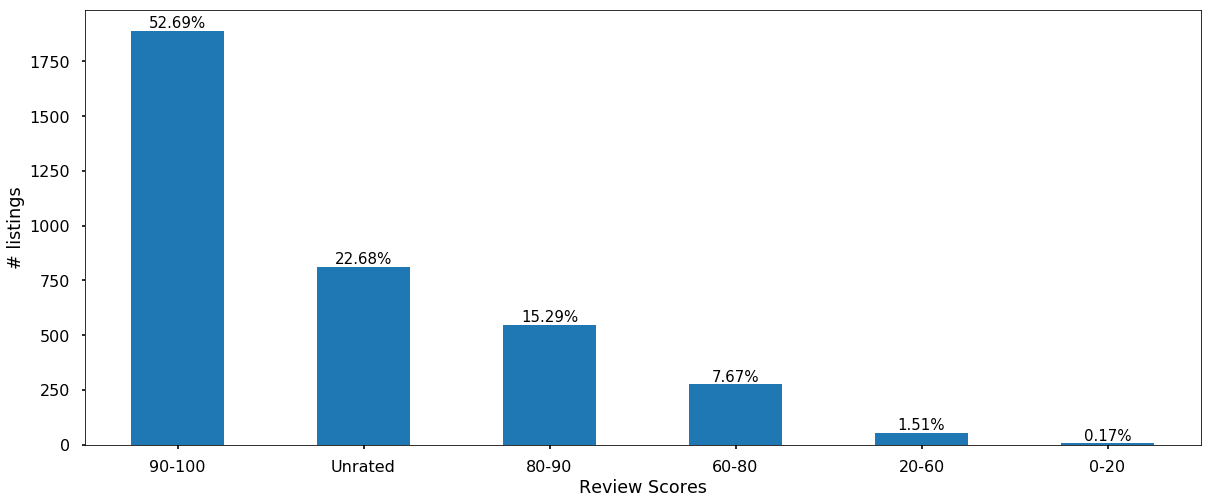

In [144]:
plt.figure(figsize =(20,8))
ax = boston_listings.rating_bins.value_counts().plot(kind='bar')

for p in ax.patches:
    height = p.get_height()
    ax.text((p.get_x() + p.get_width()/2.),
            height + 15,
            str(round((height/total)*100, 2))+'%',
            ha='center',
            color='black',
            fontsize=15)
plt.ylim(bottom = -2);
plt.xticks(rotation='horizontal')
plt.xlabel('Review Scores')
plt.ylabel('# listings')
plt.savefig('img/Boston_review_scores_5bins.png', bbox_inches="tight");

This gives a clearer picture with the numbers. Half of the reviews fall in the 90-100 range. And 23% of the listings are unrated. It is surprising that the site has less than 1% low reviews. Going ahead we will remove the 'Unrated' values to do the modelling nd we will reduce the number of bins to three.

Instead of trying to predict a continuous value we will try to predict categories into which the rating may fall. 
In this case, data also is highly skewed and the categorization may help us with better predictability for our model.

In [145]:
def bin_3_rating(rating):
    """
    Map continuous rating to 6 discrete categories
    
    Parameters:
    rating: a conitunous rating
    
    Returns:
    binned rating in one of the values ([90-100], [80-90], [0-80])
    
    """
    if rating > 90.0:
        return '90-100'
    elif rating <= 90.0 and rating > 80.0:
        return '80-90'
    else:
        return '0-80'
    assert 0  # unexpected rating

Before we go ahead with binning and modelling, let us clean and engineer some features - 
The feature engineering will consist of - 

* Drop rows with rating='Unrated'
* Columns with binary values 't' and 'f' - change them to 1 and 0
* Columns with more than one category - apply one hot encoding
* Process the amenities column - get amenities like Wifi, TV, Kitchen, 24 hour check in; also get the number of amenities
* Process columns dealing with prices - convert them to floats
* Process descriptive columns to get the length of such descriptions
* Create some new features 
    * From host_since get the number of days since the first host_since date present in the dataset
    * Using the latitude and longitude of the city center, calculate distance to the center


In [156]:
def process_binary_categories(df, cols_to_encode):
    for col in cols_to_encode:
        df.loc[:,col] = np.where(df[col] == 't', 1, 0)
    return df

In [157]:
def process_multi_categories(df, cols_to_encode):
    df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
    return df

In [158]:
def process_amenities(df):
    ## We only want to get a subset of amenities - TV, Wifi, Kitchen, Internet, Free parking, Free street parking,
    # No Smoking/ Non Smoking, 24 hour check in, heating, air conditioning
    
    ## TODO: Check if we can do this dynamically
    ## TODO: Add house rules also
    
    df.loc[:, 'amenities'] = df['amenities'].str.lower()
    df.loc[:, 'TV'] = df['amenities'].str.contains('tv').astype(int)
    df.loc[:, 'Wifi'] = df['amenities'].str.contains('wifi|internet', regex=True).astype(int)
    df.loc[:, 'Kitchen'] = df['amenities'].str.contains('kitchen').astype(int)
    df.loc[:, 'Free parking'] = df['amenities'].str.contains('free parking').astype(int)
    df.loc[:, 'Free Street parking'] = df['amenities'].str.contains('free street parking').astype(int)
    df.loc[:, 'No Smoking'] = df['amenities'].str.contains('no smoking|non smoking', regex=True).astype(int)
    df.loc[:, '24 hour check in'] = df['amenities'].str.contains('24 hour check in').astype(int)
    df.loc[:, 'Heating'] = df['amenities'].str.contains('heating').astype(int)
    df.loc[:, 'Air conditioning'] = df['amenities'].str.contains('air conditioning').astype(int)
    df.loc[:, 'num_amenities'] = df['amenities'].str.split(',').str.len()
    return df



In [159]:
def process_prices(df, cols_to_process):
    for col in cols_to_process:
        df.loc[:, col] = df[col].replace( '[\$,)]','', regex=True ).astype('float64')
        df.loc[:, col] = df[col].fillna(0)
    return df

In [160]:
def process_special(df):
    df = df.apply(lambda col: pd.to_datetime(col, errors='ignore')
              if col.dtypes == object 
              else col, 
              axis=0)
    
    max_days = df['host_since'].max()
    df.loc[:,'host_since_days'] = max_days - df['host_since']
    df.loc[:, 'host_since_days'] = df['host_since_days'].dt.days
    
    df.loc[:,'distance_center'] = df.apply(lambda x: dist.distance((x['latitude'], x['longitude']), 
                                    (42.3584300, -71.0597700)).km, axis = 1)
    
    df.loc[:,'host_response_rate'] = df['host_response_rate'].str.replace('%','').astype('float64')
    df.loc[:, 'host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%','').astype('float64')
    
    df.loc[:, 'host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].mean())
    df.loc[:, 'host_acceptance_rate'] = df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].mean())
    
    return df

In [161]:
def process_length(df):
    df.loc[:,'name_length'] = df['name'].str.len()
    df.loc[:,'summary_length'] = df['summary'].str.len()
    df.loc[:,'description_length'] = df['description'].str.len()
    df.loc[:,'amenities_length'] = df['amenities'].str.len()
    df.loc[:,'name_length'].fillna(0, inplace=True)
    df.loc[:,'summary_length'].fillna(0, inplace=True)
    df.loc[:,'description_length'].fillna(0, inplace=True)
    df.loc[:,'amenities_length'].fillna(0, inplace=True)
    return df

In [162]:
def engineer_features(df, binary_cats, multi_cats, price_cols, cols_to_be_dropped):
    
    df = process_binary_categories(df, binary_cats)

    df.loc[:, 'host_response_time'] = df['host_response_time'].astype('|S80')
    df.loc[:, 'host_response_time'] = df['host_response_time'].fillna('not available')

    df.loc[:, 'bathrooms'].fillna(df['bathrooms'].mean(), inplace=True)
    df.loc[:, 'bedrooms'].fillna(df['bedrooms'].mean(), inplace=True)
    df.loc[:, 'beds'].fillna(df['beds'].mean(), inplace=True)
    df.loc[:, 'property_type'].fillna(method='ffill', inplace=True)


    df = process_multi_categories(df, multi_cats)

    df = process_amenities(df)


    df = process_prices(df, price_cols)

    df = process_special(df)
    
    df = process_length(df)
    
    #df.drop(df.loc[df['review_scores_value']=='Unrated'].index, inplace=True)

    df.drop(cols_to_be_dropped, axis=1, inplace=True)

    return df

In [170]:
boston_listings.drop(boston_listings.loc[boston_listings['rating_bins']=='Unrated'].index, inplace=True)

In [171]:
binary_cats = ['host_is_superhost', 'host_identity_verified', 'instant_bookable']
multi_cats = ['property_type', 'room_type', 'bed_type', 'bathrooms', 'bedrooms', 'beds', 'cancellation_policy', 'neighbourhood_cleansed', 'host_response_time']
price_cols = 'price', 'cleaning_fee', 'security_deposit', 'extra_people'

In [172]:
## Drop columns we do not want
##From assessment #1 in the AssessExplore notebook
cols_to_be_dropped = ['neighbourhood_group_cleansed', 'has_availability', 'license', 'jurisdiction_names',
                     'scrape_id', 'last_scraped', 
                     'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
                     'requires_license', 'country_code' , 'country']

##After pre processing and feature engineering, in addition to categorical columns 
# Being dropped either due to missing data or the assumption that they may not contribute to the prediction
cols_to_be_dropped.extend((
'amenities', 
'id', 'experiences_offered', 
'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_value',
'review_scores_communication', 'review_scores_location', 'first_review', 'last_review', 'reviews_per_month',
'name','summary', 'space', 'description', 'neighborhood_overview','transit','notes', 'access', 'interaction', 
'house_rules', 'weekly_price', 'monthly_price', 'square_feet',
'host_id', 'host_url', 'host_location', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'host_since', 'street',
'neighbourhood', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country',
'availability_30','availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count',
'calendar_updated', 'calendar_last_scraped', 
'guests_included', 'minimum_nights', 'maximum_nights',
'is_location_exact', 'rating_bins'))

In [173]:
boston_listings = engineer_features(boston_listings, binary_cats, multi_cats, price_cols, cols_to_be_dropped)

In [174]:
boston_listings['rating_bins'] = boston_listings['review_scores_rating'].map(bin_3_rating)

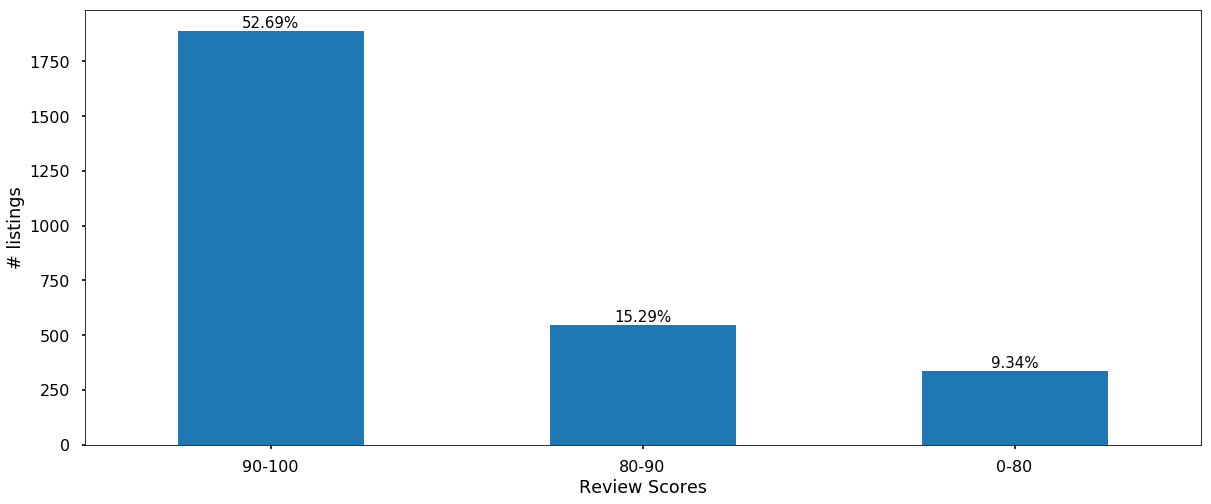

In [175]:
plt.figure(figsize =(20,8))
ax = boston_listings.rating_bins.value_counts().plot(kind='bar')

for p in ax.patches:
    height = p.get_height()
    ax.text((p.get_x() + p.get_width()/2.),
            height + 15,
            str(round((height/total)*100, 2))+'%',
            ha='center',
            color='black',
            fontsize=15)
plt.ylim(bottom = -2);
plt.xticks(rotation='horizontal')
plt.xlabel('Review Scores')
plt.ylabel('# listings')
plt.savefig('img/Boston_review_scores_3bins.png', bbox_inches="tight");

In [ ]:
This is still pretty skewed data. But we begin modelling 

### Model

In [176]:
y = boston_listings['rating_bins']
X = boston_listings.drop(['review_scores_rating', 'rating_bins'], axis = 1)

In [213]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, log_loss, precision_score, classification_report

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Logistic Regression

We will try one vs. rest logistic regression first

In [184]:
clf = LogisticRegression(multi_class='ovr', C=0.010)
logregclf = Pipeline([
        ('scaler', StandardScaler()), ('logistic', clf)])

In [185]:
logregclf.fit(X_train, y_train)
f1_score(y_test, logregclf.predict(X_test), average=None)

array([ 0.21138211,  0.27322404,  0.80555556])

In [187]:
accuracy_score(y_test, logregclf.predict(X_test))

0.68253968253968256

In [188]:
log_loss(y_test, logregclf.predict_proba(X_test))

0.81550401660786298

In [189]:
confusion_matrix(y_test, clf.predict(X_test), labels=logregclf.classes_).T

array([[  2,   0,   0],
       [ 30,  59, 138],
       [ 64,  76, 324]])

In [190]:
pd.crosstab(y_test, logregclf.predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0-80,80-90,90-100,All
True,,,,
0-80,13,6,77,96
80-90,4,25,106,135
90-100,10,17,435,462
All,27,48,618,693


In [214]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       0-80       0.56      0.25      0.35        96
      80-90       0.61      0.27      0.38       135
     90-100       0.74      0.95      0.83       462

avg / total       0.69      0.72      0.68       693



### Random Forest Classifier

In [191]:
def get_test_rf_classifier():
    """
    The Random Forest pipeline to use to get the best estimator
    """
    scaler = StandardScaler()
    clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                                                  max_features='auto', max_depth=None,
                                                  n_jobs=4, class_weight='balanced_subsample')
    pipe = Pipeline([
            ('scaler', scaler), ('clf', clf)])
    param_grid={'clf__max_features': [10, 30, 50, 70, 90, 97]}
    grid_clf = GridSearchCV(pipe, param_grid=param_grid, scoring=class_weighted_accuracy_score, 
                                                n_jobs=1, cv=3, verbose=1)
    return grid_clf

def get_final_rf_pipe(num_estimators, criterion, max_feat, max_depth, num_jobs, class_weight):
    """
    The final Random Forest pipeline with the best estimator
    """
    scaler = StandardScaler()
    final_clf = RandomForestClassifier(n_estimators=num_estimators,
                                                      criterion=criterion,
                                                      max_features=max_feat,
                                                      max_depth=max_depth,
                                                      n_jobs=num_jobs,
                                                      class_weight=class_weight)
    final_rf_pipe = Pipeline([('scaler', scaler), ('clf', final_clf)])
    return final_rf_pipe

In [192]:
def make_weight(y):
    """
    Return sample weights according to inverse class frequency
    y: Series of labels
    """
    weight_dict = dict(1/y.value_counts())
    return y.map(weight_dict)


def class_weighted_accuracy_score(estimator, X, y):
    """
    Scorer that uses accuracy after reweighting samples by class frequency
    """
    return skl.metrics.accuracy_score(y, estimator.predict(X),
                                      sample_weight=make_weight(y))

In [193]:
gridclf = get_test_rf_classifier()
gridclf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    8.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            mi...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__max_features': [10, 30, 50, 70, 90, 97]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function class_weighted_accuracy_score at 0x1a1a47c2f0>,
       verbose=1)

In [194]:
gridclf.grid_scores_

[mean: 0.42611, std: 0.00736, params: {'clf__max_features': 10},
 mean: 0.42839, std: 0.00916, params: {'clf__max_features': 30},
 mean: 0.43888, std: 0.00875, params: {'clf__max_features': 50},
 mean: 0.43867, std: 0.00371, params: {'clf__max_features': 70},
 mean: 0.44473, std: 0.00382, params: {'clf__max_features': 90},
 mean: 0.43795, std: 0.00812, params: {'clf__max_features': 97}]

In [195]:
gridclf.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=90,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_im...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [196]:
final_rf_pipe = get_final_rf_pipe(100, 'gini', 90, None, 4, 'balanced_subsample')

In [197]:
final_rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=90,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_im...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [198]:
class_weighted_accuracy_score(final_rf_pipe, X_test, y_test)

0.49070867404200741

In [205]:
y_pred = final_rf_pipe.predict(X_test)

In [206]:
confusion_matrix(y_test, y_pred, labels=final_rf_pipe.classes_).T

array([[ 24,  12,   7],
       [  7,  37,  17],
       [ 65,  86, 438]])

In [207]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0-80,80-90,90-100,All
True,,,,
0-80,24,7,65,96
80-90,12,37,86,135
90-100,7,17,438,462
All,43,61,589,693


In [210]:
precision_score(y_test, y_pred, average='weighted')

0.69123407662982161

In [212]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       0-80       0.56      0.25      0.35        96
      80-90       0.61      0.27      0.38       135
     90-100       0.74      0.95      0.83       462

avg / total       0.69      0.72      0.68       693



In [202]:
feature_importances = pd.DataFrame(final_rf_pipe.named_steps['clf'].feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 
                                                                        ascending=False)

In [203]:
feature_importances

,importance
number_of_reviews,0.136897
host_since_days,0.058940
host_is_superhost,0.058107
amenities_length,0.057110
distance_center,0.056008
latitude,0.054490
longitude,0.051024
summary_length,0.050477
price,0.047977
name_length,0.041134


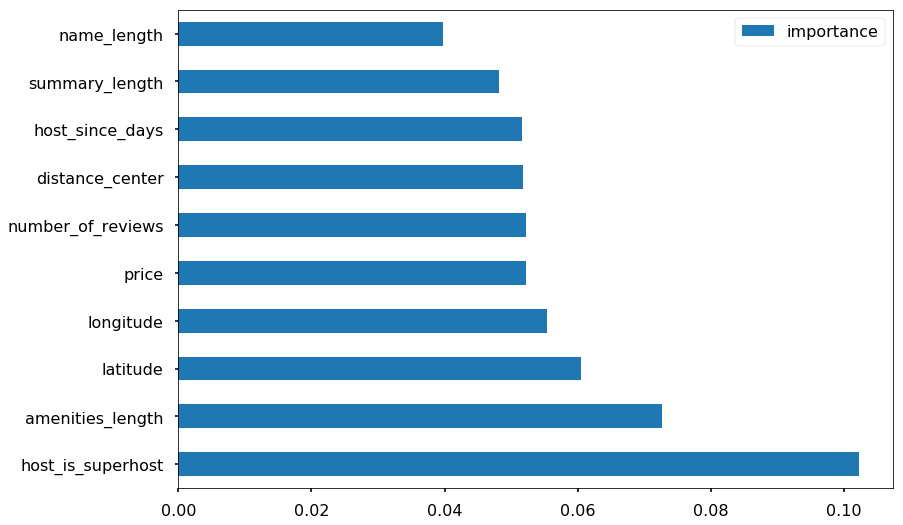

In [251]:
feature_importances.nlargest(10, 'importance').plot(kind='barh')
plt.savefig('img/feature_importance_3bins.png', bbox_inches="tight");

Let us try with two bins only - 90+ and 90- and see if our precision increases

In [217]:
def bin_2_rating(rating):
    """
    Map continuous rating to 2 discrete categories
    
    Parameters:
    rating: a conitunous rating
    
    Returns:
    binned rating in one of the values ([90+], [90-])
    
    """
    if rating == '90-100':
        return '90+'
    else:
        return '90-'
    assert 0  # unexpected rating

In [218]:
boston_listings['rating_bins'] = boston_listings['rating_bins'].map(bin_2_rating)

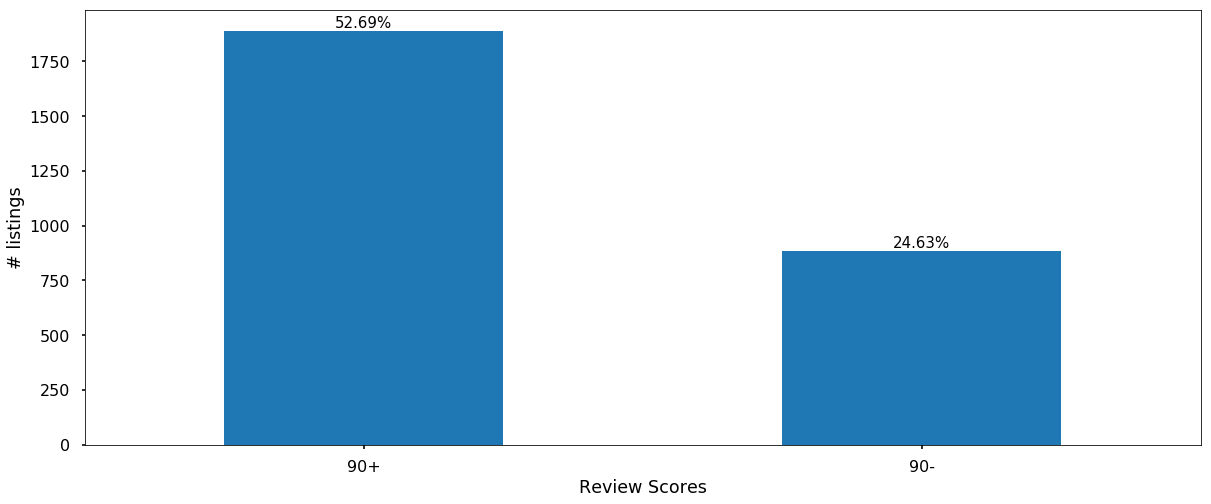

In [219]:
plt.figure(figsize =(20,8))
ax = boston_listings.rating_bins.value_counts().plot(kind='bar')

for p in ax.patches:
    height = p.get_height()
    ax.text((p.get_x() + p.get_width()/2.),
            height + 15,
            str(round((height/total)*100, 2))+'%',
            ha='center',
            color='black',
            fontsize=15)
plt.ylim(bottom = -2);
plt.xticks(rotation='horizontal')
plt.xlabel('Review Scores')
plt.ylabel('# listings')
plt.savefig('img/Boston_review_scores_2bins.png', bbox_inches="tight");

### Model

In [220]:
y = boston_listings['rating_bins']
X = boston_listings.drop(['review_scores_rating', 'rating_bins'], axis = 1)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Logistic Regression again

In [222]:
clf = LogisticRegression(multi_class='ovr', C=0.010)
logregclf = Pipeline([
        ('scaler', StandardScaler()), ('logistic', clf)])

In [223]:
logregclf.fit(X_train, y_train)
f1_score(y_test, logregclf.predict(X_test), average=None)

array([ 0.79609756,  0.42105263])

In [224]:
accuracy_score(y_test, logregclf.predict(X_test))

0.69841269841269837

In [225]:
log_loss(y_test, logregclf.predict_proba(X_test))

0.58917460162221535

In [229]:
y_pred = logregclf.predict(X_test)

In [230]:
confusion_matrix(y_test, y_pred, labels=logregclf.classes_).T

array([[408, 155],
       [ 54,  76]])

In [231]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,90+,90-,All
True,,,
90+,408,54,462
90-,155,76,231
All,563,130,693


In [232]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        90+       0.72      0.88      0.80       462
        90-       0.58      0.33      0.42       231

avg / total       0.68      0.70      0.67       693



### Random Forest Classifier

In [235]:
gridclf = get_test_rf_classifier()
gridclf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    9.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            mi...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__max_features': [10, 30, 50, 70, 90, 97]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function class_weighted_accuracy_score at 0x1a1d085d08>,
       verbose=1)

In [236]:
gridclf.grid_scores_

[mean: 0.61323, std: 0.00370, params: {'clf__max_features': 10},
 mean: 0.61726, std: 0.00330, params: {'clf__max_features': 30},
 mean: 0.61836, std: 0.00555, params: {'clf__max_features': 50},
 mean: 0.61805, std: 0.00828, params: {'clf__max_features': 70},
 mean: 0.61919, std: 0.00458, params: {'clf__max_features': 90},
 mean: 0.61480, std: 0.00410, params: {'clf__max_features': 97}]

In [237]:
gridclf.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=90,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_im...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [238]:
final_rf_pipe = get_final_rf_pipe(100, 'gini', 90, None, 4, 'balanced_subsample')

In [239]:
final_rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=90,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_im...mators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [240]:
class_weighted_accuracy_score(final_rf_pipe, X_test, y_test)

0.65259740259740262

In [241]:
y_pred = final_rf_pipe.predict(X_test)

In [242]:
confusion_matrix(y_test, y_pred, labels=final_rf_pipe.classes_).T

array([[413, 136],
       [ 49,  95]])

In [243]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,90+,90-,All
True,,,
90+,413,49,462
90-,136,95,231
All,549,144,693


In [244]:
precision_score(y_test, y_pred, average='weighted')

0.72142531876138427

In [245]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        90+       0.75      0.89      0.82       462
        90-       0.66      0.41      0.51       231

avg / total       0.72      0.73      0.71       693



In [246]:
feature_importances = pd.DataFrame(final_rf_pipe.named_steps['clf'].feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 
                                                                        ascending=False)

In [247]:
feature_importances

,importance
host_is_superhost,0.102237
amenities_length,0.072716
latitude,0.060513
longitude,0.055415
price,0.052279
number_of_reviews,0.052185
distance_center,0.051729
host_since_days,0.051677
summary_length,0.048203
name_length,0.039753


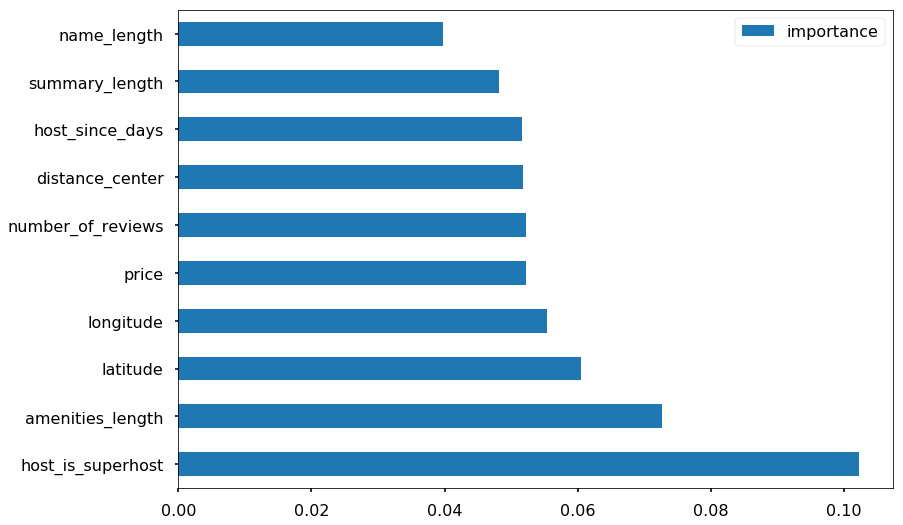

In [250]:
feature_importances.nlargest(10, 'importance').plot(kind='barh')
plt.savefig('img/feature_importance_2bins.png', bbox_inches="tight");

As should be obvious we get better results with two categories instead of three. This is partly because the data points for the lower than 90 category has increased.

The Random Forest classifier is able to predict the 90+ category with 75% precision and 90- category with 66% precision. These are good results with the number of data points that we have

What can be looked at further would be - 
* Collecting more data
* Engineering more complex features - like distance to nearest subway stations, cleanliness from the cleanliness reviews  etc